# Notebook 1: Generating samples from different Gaussian process kernels

### Covariance functions are also called kernel functions. In this exercise we'll draw samples from different kernels to see how they look and how they are affected by the choice of hyper-parameters.

### It can be helpful to sample artificial data from your model. This can lead to a better understanding of its typical properties and the assumptions you are making. If the model does not produce realistic data then you may not be able to trust the inferences that you make when using it.


### Try changing the hyper-parameters in the kernels below to see how the samples and covariance matrix are affected in each case. 

Notebook created by Sumon Ahmed, Magnus Rattray and Alexis Boukouvalas. We are using the gpflow package from Matthews et al. (2017) "GPflow: A Gaussian process library using TensorFlow" The Journal of Machine Learning Research, 18(1), 1299-1304.

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow
import sys
tf.logging.set_verbosity(tf.logging.ERROR) # Suppresses outputs from tensorflow

In [11]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

In [12]:
def plotkernelsample(k, ax, xmin, xmax, sampleSize, n_sample=1):
    xx = np.linspace(xmin, xmax, sampleSize)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(sampleSize), K, n_sample).T)
    ax.set_xlim([xmin, xmax])

In [13]:
def plotCovarianceMatrix(k, ax, xmin, xmax, sampleSize):
    xx = np.linspace(xmin, xmax, sampleSize)[:,None]
    K = k.compute_K_symm(xx)
    im = ax.matshow(K, cmap=plt.cm.jet)
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=ax)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.tick_params(labelsize=16)

# Set the range and number of time points sampled

### With enough sampled time points, the samples will no longer look like sets of discrete points but will look like continuous functions. 

In [14]:
a = 0.
b = 20.
sampleSize = 200 # How many time points are sampled to approximate the function
x = np.linspace(a, b, sampleSize)[:, None]

# 1. Squared exponential kernel 

## $ k\left(t,t^{\prime}\right)=\alpha\exp\left(-\frac{\left(t-t^{\prime}\right)^{2}}{l^{2}}\right) $

### The squared exponential has two hyper-parameters, the lengthscale ($l$) and variance ($\alpha$). I'm using $\alpha$ for the variance to avoid confusion with the noise variance of the data. 

### Below we show some samples on the left and we show the covariance matrix of the samples on the right

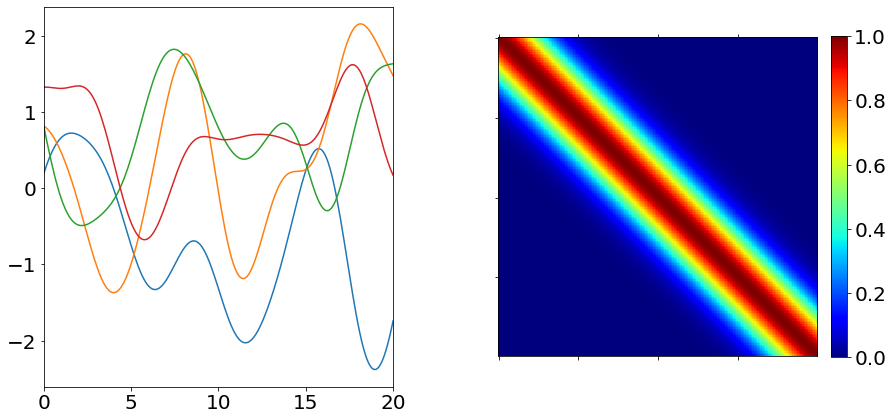

In [15]:
k_rbf = gpflow.kernels.RBF(1)
k_rbf.lengthscales = 2. # Determines how often the function crosses zero on average (wiggliness) 
k_rbf.variance = 1.     # Typical amplitude (marginal variance) of the function
n_sample = 4

np.random.seed(1) # Change this to see some different samples

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)
plotkernelsample(k_rbf, ax[0], a, b, sampleSize, n_sample)
plotCovarianceMatrix(k_rbf, ax[1], a, b, sampleSize)

# 2. Smooth periodic kernel

##  $ k\left(t,t^{\prime}\right)=\alpha\exp\left(-\frac{sin^2\left(\pi\frac{t-t^{\prime}}{\lambda}\right)}{l^2}\right) $

### From MacKay, D. J. (1998). Introduction to Gaussian processes. NATO ASI Series F Computer and Systems Sciences, 168, 133-166. http://www.inference.org.uk/mackay/gpB.pdf (page 15). Samples are smooth, periodic functions, with similar smoothness to the RBF kernel above. 

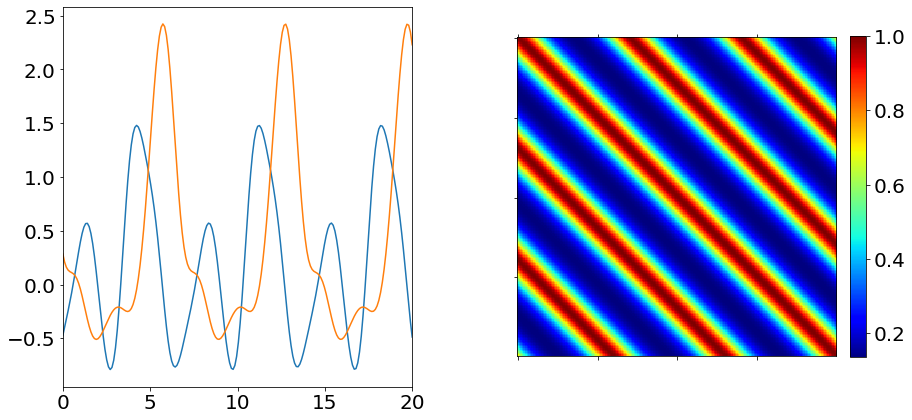

In [16]:
k_per = gpflow.kernels.Periodic(1)
k_per.lengthscales = 0.5
k_per.variance = 1.
k_per.period = 7.
n_sample = 2

np.random.seed(6) # Change this to get a different sample

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)
plotkernelsample(k_per, ax[0], a, b, sampleSize, n_sample)
plotCovarianceMatrix(k_per, ax[1], a, b, sampleSize)

# 3. OU (Ornstein Uhlenbeck)

## $ k\left(t,t^{\prime}\right)=\alpha\exp\left(-\frac{|t-t^{\prime}|}{l}\right) $

### This may be familiar to physicists as the covariance of a particle diffusing by Brownian motion in a potential well. This is the roughest kernel in the Matern class (with parameter $\nu = 1/2$). Matern3/2 and Matern5/2 produce smoother (more differentiable) samples and as $\nu \rightarrow \infty$ we get the RBF kernel above. 

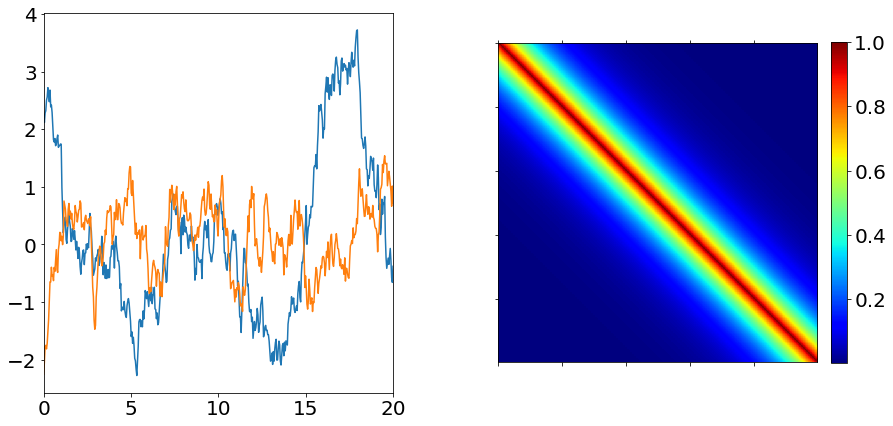

In [17]:
k_ou = gpflow.kernels.Matern12(1) # Special case of more general Matern kernel class
k_ou.variance = 1.0
k_ou.lengthscales = 2.0
n_sample = 2
sampleSize = 500 # Since this is rougher, we sample more time points to see an accurate path

np.random.seed(8) # Change this to get a different sample

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)
plotkernelsample(k_ou, ax[0], a, b, sampleSize, n_sample)
plotCovarianceMatrix(k_ou, ax[1], a, b, sampleSize)

# 4. OU_Periodic

## $k\left(t,t^{\prime}\right)=\alpha\exp\left(-\frac{|t-t^{\prime}|}{l}\right)cos\left (\frac{|t-t^{\prime}|}{l_{cos}}\right )$

### Here, we have used the $OU$ kernel above and multiplied it by a cosine kernel where $l_{cos}$ is the lengthscale (determining the period) of the Cosine kernel. This is a simple example of how two kernels can be combined to produce a new one. 

### This covariance function was recently used to identify oscillatory genes: Phillips et al. "Identifying stochastic oscillations in single-cell live imaging time series using Gaussian processes." PLoS computational biology 13.5 (2017): e1005479. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005479

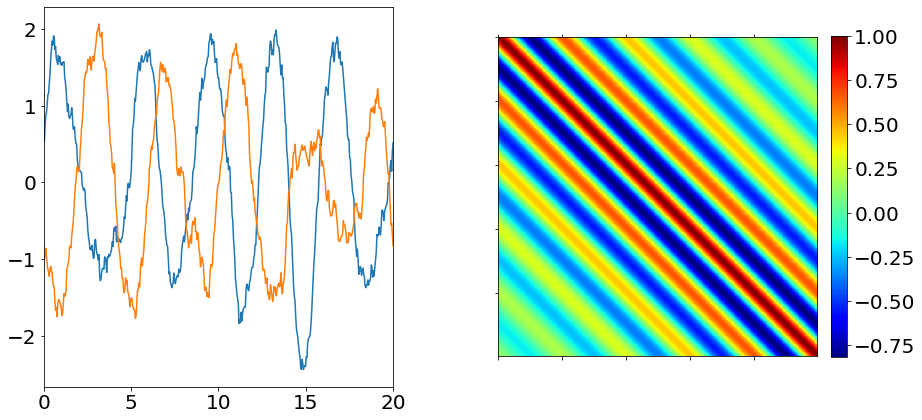

In [18]:
k_cos = gpflow.kernels.Cosine(1)
k_cos.lengthscales = 2.0/np.pi # Using units of pi to be consistent with smooth periodic kernel above
k_cos.variance = 1.            # We don't need two variances so we can just fix this to one
k_ou.variance = 1.             # Determines the amplitude (marginal variance) of the signal
k_ou.lengthscales = 10.        # Determines the roughness and how quickly phase information is lost
n_sample = 2

k_ou_per = k_ou * k_cos

np.random.seed(1) # Change this to get a different sample

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)
plotkernelsample(k_ou_per, ax[0], a, b, sampleSize, n_sample)
plotCovarianceMatrix(k_ou_per, ax[1], a, b, sampleSize)